# Парсер HeadHunter
## Цель :
* Научиться делать парсер, чтобы получать те вакансии, которые интересны именно мне
* Расширить портфолио проектов

## Библиотеки и инструменты:
* requests - для отправки запросов к API HH
* pandas - для формирования таблицы 
* matplotlib, seaborn - визуализация
* json - формат обмена данными, будем использовать для декодирования ответов в удобном формате
* IPython - для магических штук
* BeautifulSoup - библиотека Python для извлечения данных из файлов HTML и XML

### Импорт библиотек

In [1]:
import requests
import pandas as pd
import numpy as np

import json

from datetime import datetime, timedelta
import time
import os
from IPython.core.display import display, HTML, clear_output
import ipywidgets as widgets
from typing import Union

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\selezneva\AppData\Local\Temp\ipykernel_3236\2055726921.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output
C:\Users\selezneva\AppData\Local\Temp\ipykernel_3236\2055726921.py:10: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output


### Делаем выгрузку из HeadHunter
Ссылка на API HH: https://github.com/hhru/api \
Для того, чтобы написать запрос используется язык поисковых запросов, задокументированный тут: https://hh.ru/article/1175 \
Фильтрацию можно делать в самом запросе, например, сделать поиск по полю компаний или же по наличию конкретного текста в описании, где COMPANY_NAME - название компании, а DESCRIPTION - описание вакансии. Язык запросов работает и на обычном сайте hh.ru, что бывает полезно.

Создадим необходимые константы: BASE_URL

In [2]:
BASE_URL = "https://api.hh.ru/"

#TEXT = f'NAME:("Machine Learning Engineer" OR "Data Scientist" OR "Дата саентист" OR "Machine Learning Developer" or "Machine Learning Researcher" or "Искусственный интеллект" or "Машинное обучение" or "Специалист по machine learning" or "Специалист по машинному обучению" or "AI engineer" or "Разработчик ML" or "Data Science" or "Machine Learning" or "Artificial Intelligence" or "ML Engineer" or "Аналитик" or "Analyst" or "Data Engineer" or "DWH" or "BI" or "Business Intelligence" or "Data инженер" or "Инженер данных" or "ETL" or "КХД")'
TEXT = f'SQL NAME:("Аналитик" or "Analyst" or "DWH" or "BI" or "Business Intelligence" or "ETL" or "КХД")'

dt_now = datetime.now().date()
dt_from = dt_now - timedelta(days=7)
DATE_TO = dt_now.isoformat() #API требует дату в формате ISO 8601 YYYY-MM-DD или YYYY-MM-DDThh:mm:ss±hhmm
DATE_FROM = dt_from.isoformat()

VAC_URL = BASE_URL + f'vacancies?text={TEXT}&date_from={DATE_FROM}&date_to={DATE_TO}&responses_count_enabled=True&per_page=100'

In [3]:
vacancy_df = pd.DataFrame() # создаем датафрейм в который будем сохранять наши данные

В выдаче API HH нет опыта работы, поэтому мы укажем его в запросе самостоятельно:\
Можно выбрать подходящий. Важно помнить, что можно откликаться на вакансии «от 1 года опыта» :)

In [4]:
experiences = ['noExperience',
               'between1And3',
               'between3And6', 
               'moreThan6']

Напишем цикл для направления запросов к API

In [5]:
for exp in experiences:
    page = 0
    url = VAC_URL +f'&experience={exp}'
    try:
        r = requests.get(url + f'&page={page}')
        data = json.loads(r.text)
        print(exp,' - ', data['pages'])
        items = data['items']
        for page in range(1, data['pages']):
            r = requests.get(url + f'&page={page}')
            data = json.loads(r.text)
            items += data['items']
        df = pd.DataFrame(items)
        df['experience'] =exp
        vacancy_df = pd.concat([vacancy_df, df])
            
            
    except Exception as e:
        print(exp, '-', e)
        time.sleep(5)

noExperience  -  1
between1And3  -  11
between3And6  -  7
moreThan6  -  1


In [6]:
vacancy_df

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience
0,67463413,False,Разработчик (DWH),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '2737', 'name': 'АБСОЛЮТ БАНК', 'url': ...",{'requirement': '<highlighttext>SQL</highlight...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 6},[],[],[],False,noExperience
1,66577548,False,Главный инженер разработки (DWH/ ETL),"{'id': '3388-3388-gazprom', 'name': 'Газпромба...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3388', 'name': 'Газпромбанк', 'url': '...",{'requirement': 'Высшее образование (прикладна...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 3},[],[],[],False,noExperience
2,43342136,False,Аналитик SQL,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Замоскворецкая л...",...,"{'id': '78638', 'name': 'Тинькофф', 'url': 'ht...",{'requirement': 'Высшее техническое/математиче...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 20},[],[],[],False,noExperience
3,54622771,False,Аналитик,None,False,False,"{'id': '1730', 'name': 'Муром', 'url': 'https:...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Муром', 'street': 'улица Ленина', 'b...",...,"{'id': '221768', 'name': 'Ред Софт', 'url': 'h...",{'requirement': 'Высшее техническое образовани...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 1},[],[],[],False,noExperience
4,53211965,False,"Аналитик данных (sql, excel)",None,False,False,"{'id': '112', 'name': 'Ярославль', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Ярославль', 'street': 'улица Чайковс...",...,"{'id': '1613743', 'name': 'КЭШОФФ', 'url': 'ht...","{'requirement': 'Любишь разбираться в данных, ...",None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 8},[],[],[],False,noExperience
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,66882679,False,"System analyst / Системный аналитик, продуктов...",None,False,True,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 200000, 'to': 300000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '21999', 'name': 'Финансовые Платформы'...",{'requirement': 'Высшее техническое образовани...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 4},[],[],[],False,moreThan6
29,66574166,False,Ведущий системный аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '6106622', 'name': 'B2Broker', 'url': '...",{'requirement': 'Педантичность высокого уровня...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 6},[],[],[],False,moreThan6
30,66574167,False,Ведущий системный аналитик,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '6106622', 'name': 'B2Broker', 'url': '...",{'requirement': 'Педантичность высокого уровня...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 3},[],[],[],False,moreThan6
31,67317617,False,Старший системный аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'проспект Вернадс...",...,"{'id': '3191643', 'name': 'ЦИФРА', 'url': 'htt...",{'requirement': 'имеете опыт администрирования...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 2},[],[],[],False,moreThan6


Введем свежие индексы и выведем таблицу на экран.

In [7]:
vacancy_df.reset_index(drop=True, inplace=True)

In [8]:
vacancy_df

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience
0,67463413,False,Разработчик (DWH),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '2737', 'name': 'АБСОЛЮТ БАНК', 'url': ...",{'requirement': '<highlighttext>SQL</highlight...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 6},[],[],[],False,noExperience
1,66577548,False,Главный инженер разработки (DWH/ ETL),"{'id': '3388-3388-gazprom', 'name': 'Газпромба...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3388', 'name': 'Газпромбанк', 'url': '...",{'requirement': 'Высшее образование (прикладна...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 3},[],[],[],False,noExperience
2,43342136,False,Аналитик SQL,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Замоскворецкая л...",...,"{'id': '78638', 'name': 'Тинькофф', 'url': 'ht...",{'requirement': 'Высшее техническое/математиче...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 20},[],[],[],False,noExperience
3,54622771,False,Аналитик,None,False,False,"{'id': '1730', 'name': 'Муром', 'url': 'https:...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Муром', 'street': 'улица Ленина', 'b...",...,"{'id': '221768', 'name': 'Ред Софт', 'url': 'h...",{'requirement': 'Высшее техническое образовани...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 1},[],[],[],False,noExperience
4,53211965,False,"Аналитик данных (sql, excel)",None,False,False,"{'id': '112', 'name': 'Ярославль', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Ярославль', 'street': 'улица Чайковс...",...,"{'id': '1613743', 'name': 'КЭШОФФ', 'url': 'ht...","{'requirement': 'Любишь разбираться в данных, ...",None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 8},[],[],[],False,noExperience
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,66882679,False,"System analyst / Системный аналитик, продуктов...",None,False,True,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 200000, 'to': 300000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '21999', 'name': 'Финансовые Платформы'...",{'requirement': 'Высшее техническое образовани...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 4},[],[],[],False,moreThan6
1868,66574166,False,Ведущий системный аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '6106622', 'name': 'B2Broker', 'url': '...",{'requirement': 'Педантичность высокого уровня...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 6},[],[],[],False,moreThan6
1869,66574167,False,Ведущий системный аналитик,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '6106622', 'name': 'B2Broker', 'url': '...",{'requirement': 'Педантичность высокого уровня...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 3},[],[],[],False,moreThan6
1870,67317617,False,Старший системный аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'проспект Вернадс...",...,"{'id': '3191643', 'name': 'ЦИФРА', 'url': 'htt...",{'requirement': 'имеете опыт администрирования...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 2},[],[],[],False,moreThan6


In [9]:
vacancy_df.info() #получаем информацию о полученной таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872 entries, 0 to 1871
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1872 non-null   object
 1   premium                   1872 non-null   bool  
 2   name                      1872 non-null   object
 3   department                313 non-null    object
 4   has_test                  1872 non-null   bool  
 5   response_letter_required  1872 non-null   bool  
 6   area                      1872 non-null   object
 7   salary                    336 non-null    object
 8   type                      1872 non-null   object
 9   address                   896 non-null    object
 10  response_url              0 non-null      object
 11  sort_point_distance       0 non-null      object
 12  published_at              1872 non-null   object
 13  created_at                1872 non-null   object
 14  archived                

### Вытащим ценную информацию из словарей

In [10]:
#создаем функцию, с помощью которой далее будем создавать нужные нам столбцы
def return_id(x, key='id', nan_value=np.nan):
    try:
        return x[key]
    except Exception as e:
        return nan_value

In [11]:
#создание столбцов с названием фирмы работодателя, подразделением, зарплатой от и до, информацие о вычете налогов, валюте, количестве откликов и городе
vacancy_df['employer_name'] = vacancy_df['employer'].apply(return_id, key='name')
vacancy_df['department_name'] = vacancy_df['department'].apply(return_id, key='name')
vacancy_df['salary_from'] = vacancy_df['salary'].apply(return_id, key='from')
vacancy_df['salary_to'] = vacancy_df['salary'].apply(return_id, key='to')
vacancy_df['salary_gross'] = vacancy_df['salary'].apply(return_id, key='gross')
vacancy_df['salary_currency'] = vacancy_df['salary'].apply(return_id, key='currency')
vacancy_df['responses'] = vacancy_df['counters'].apply(return_id, key='responses')
vacancy_df['city'] = vacancy_df['area'].apply(return_id, key='name')
vacancy_df['metro_stations'] = vacancy_df['address'].apply(return_id, key='metro')
vacancy_df['metro_station'] = vacancy_df['metro_stations'].apply(return_id, key='station_name')

In [12]:
vacancy_df.head(5)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,responses,city,metro_stations,metro_station
0,67463413,False,Разработчик (DWH),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,АБСОЛЮТ БАНК,NaN,NaN,NaN,NaN,NaN,6,Москва,NaN,NaN
1,66577548,False,Главный инженер разработки (DWH/ ETL),"{'id': '3388-3388-gazprom', 'name': 'Газпромба...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,Газпромбанк,Газпромбанк,NaN,NaN,NaN,NaN,3,Москва,NaN,NaN
2,43342136,False,Аналитик SQL,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Замоскворецкая л...",...,Тинькофф,NaN,NaN,NaN,NaN,NaN,20,Москва,"{'station_name': 'Водный стадион', 'line_name'...",Водный стадион
3,54622771,False,Аналитик,None,False,False,"{'id': '1730', 'name': 'Муром', 'url': 'https:...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Муром', 'street': 'улица Ленина', 'b...",...,Ред Софт,NaN,NaN,NaN,NaN,NaN,1,Муром,None,NaN
4,53211965,False,"Аналитик данных (sql, excel)",None,False,False,"{'id': '112', 'name': 'Ярославль', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Ярославль', 'street': 'улица Чайковс...",...,КЭШОФФ,NaN,NaN,NaN,NaN,NaN,8,Ярославль,None,NaN


### Про дубликаты

Найдем дубликаты по названию фирмы, вакансии и городу.

In [13]:
vacancy_df[vacancy_df.duplicated(['employer_name','name','city'], keep=False)][['employer_name','name','city','experience']].sort_values(by=['name'])

,employer_name,name,city,experience
991,СБЕР,ETL разработчик,Москва,between1And3
246,СБЕР,ETL разработчик,Москва,between1And3
154,Aston,System Analyst,Казань,between1And3
717,Aston,System Analyst,Казань,between1And3
30,Лига Цифровой Экономики,Аналитик,Санкт-Петербург,noExperience
...,...,...,...,...
1332,Газпромбанк,Системный аналитик (Омниканальная платформа),Москва,between3And6
1346,Enjoypro,Системный аналитик (витрины данных),Санкт-Петербург,between3And6
1336,Enjoypro,Системный аналитик (витрины данных),Санкт-Петербург,between3And6
1026,РОСБАНК,Системный/бизнес аналитик,Москва,between1And3


### Посмотрим компании, предлагающие вакансии, а также города

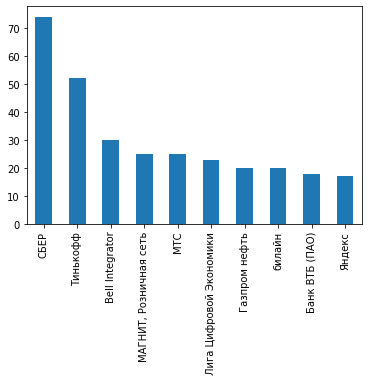

In [14]:
#гистограмма по названию фирмы
vacancy_df['employer_name'].value_counts().head(10).plot(kind='bar')
plt.show()

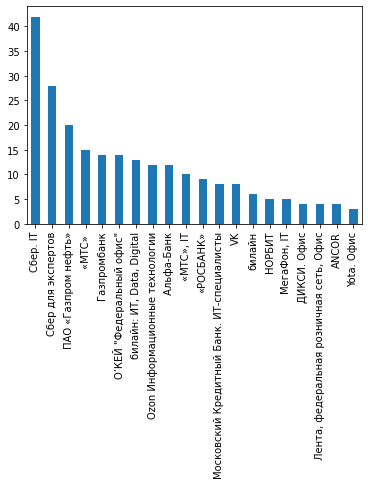

In [15]:
#гистограмма по подразделению
vacancy_df['department_name'].value_counts().head(20).plot(kind='bar')
plt.show()

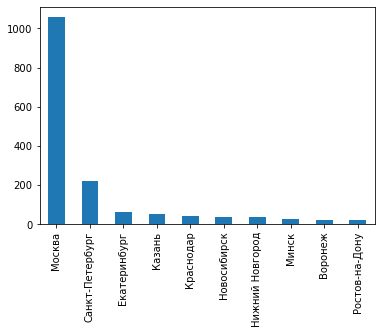

In [16]:
#гистограмма по городу
vacancy_df['city'].value_counts().head(10).plot(kind='bar')
plt.show()

### Что с зарплатой?

In [17]:
#процент вакансий не указывающих заработную плату от
vacancy_df['salary_from'].isna().value_counts(normalize=True)

True     0.856303
False    0.143697
Name: salary_from, dtype: float64

In [18]:
#процент вакансий не указывающих заработную плату до
vacancy_df['salary_to'].isna().value_counts(normalize=True)

True     0.891026
False    0.108974
Name: salary_to, dtype: float64

In [19]:
#процент валют заработной платы
vacancy_df['salary_currency'].value_counts(normalize=True)

RUR    0.940476
USD    0.041667
KZT    0.008929
BYR    0.005952
EUR    0.002976
Name: salary_currency, dtype: float64

Создадим усеченную таблицу с названием фирмы и подразделения, где необходимый опыт работы от 1 до 3 лет или без опыта, а заработная плата в рублях.

In [20]:
salaries = vacancy_df.query('salary_currency == "RUR" and experience == "between1And3" or experience == "noExperience"').groupby(['employer_name','department_name']).mean()['salary_from'].reset_index()

In [21]:
salaries

,employer_name,department_name,salary_from
0,BI.ZONE,BI.ZONE Направление Кибербезопасность,NaN
1,Boxberry,Boxberry: Офис,100000.0
2,Газпромбанк,Газпромбанк,NaN
3,"ДИКСИ, группа компаний",ДИКСИ. Офис,80000.0
4,"Лента, федеральная розничная сеть","Лента, федеральная розничная сеть, Офис",NaN
5,МТС,«МТС»,61250.0
6,МТС Банк,МТС Банк. Начало Карьеры,NaN
7,МегаФон,"МегаФон, IT",63000.0
8,СБЕР,Сбер для экспертов,70000.0
9,СБЕР,Сбер. IT,145000.0


Построим гистограмму по названию фирм с предложенной заработной платой от.

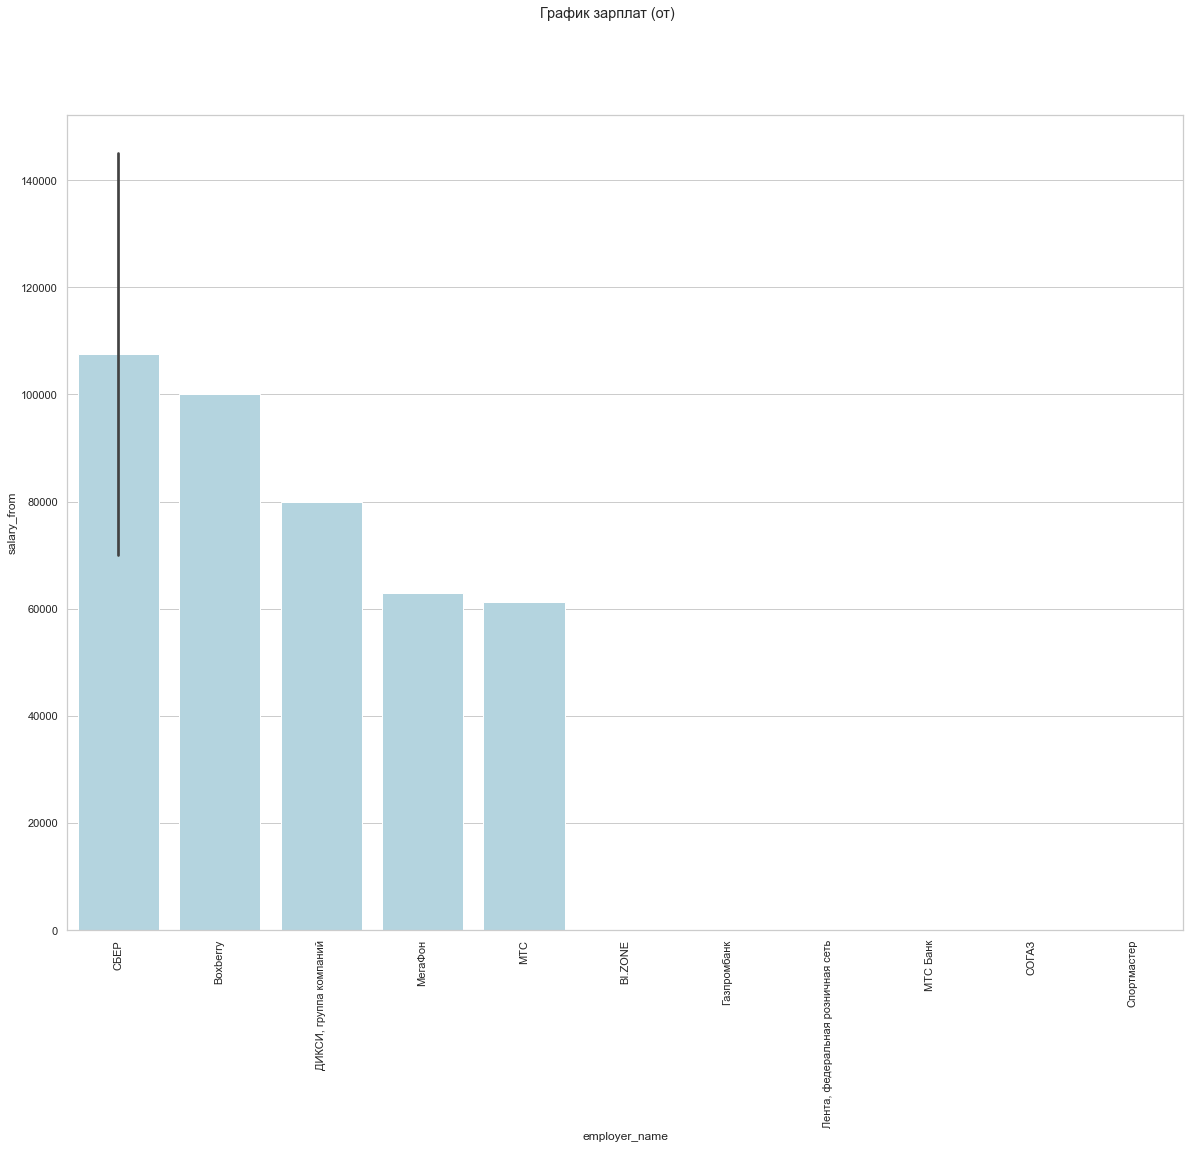

In [22]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='employer_name', y='salary_from', color='lightblue', ax=ax)
plt.show()

Построим график по названию подразделения с заработной платой от.

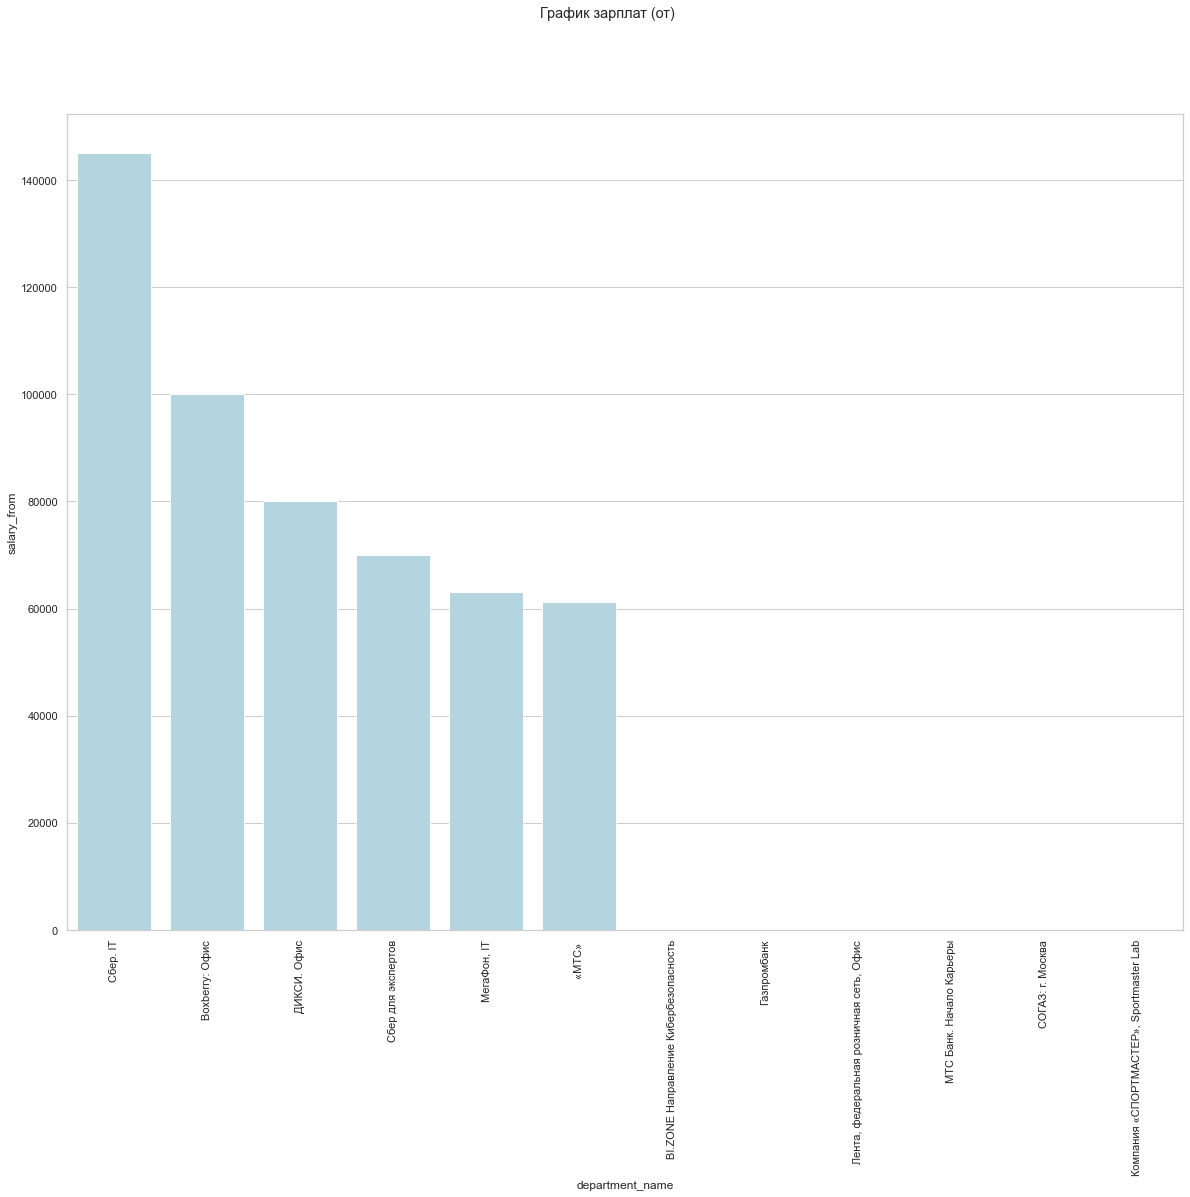

In [24]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='department_name', y='salary_from', color='lightblue', ax=ax)
plt.show()

### Давайте поищем вакансии

Так как я живу в Санкт-Петербурге, посмотрю вакансии для этого города по своей специальности.

In [25]:
city_vacs = vacancy_df[vacancy_df['city']=='Санкт-Петербург']

In [26]:
city_vacs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 15 to 1871
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        220 non-null    object 
 1   premium                   220 non-null    bool   
 2   name                      220 non-null    object 
 3   department                43 non-null     object 
 4   has_test                  220 non-null    bool   
 5   response_letter_required  220 non-null    bool   
 6   area                      220 non-null    object 
 7   salary                    39 non-null     object 
 8   type                      220 non-null    object 
 9   address                   82 non-null     object 
 10  response_url              0 non-null      object 
 11  sort_point_distance       0 non-null      object 
 12  published_at              220 non-null    object 
 13  created_at                220 non-null    object 
 14  archived

In [27]:
city_vacs.head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,responses,city,metro_stations,metro_station
15,55312993,False,Аналитик центра поддержки клиентов,"{'id': '7172-7172-ofis', 'name': 'Лента, федер...",False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Таллинс...",...,"Лента, федеральная розничная сеть","Лента, федеральная розничная сеть, Офис",NaN,NaN,NaN,NaN,166,Санкт-Петербург,None,NaN
30,67394376,False,Аналитик,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,Лига Цифровой Экономики,NaN,NaN,NaN,NaN,NaN,156,Санкт-Петербург,NaN,NaN
49,55861158,False,Data analyst (India),None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,Finstar Financial Group,NaN,NaN,NaN,NaN,NaN,27,Санкт-Петербург,NaN,NaN
59,66531903,False,Ассистент аналитика,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'from': None, 'to': 60000, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Звездна...",...,Монополия,NaN,NaN,60000.0,True,RUR,207,Санкт-Петербург,"{'station_name': 'Звёздная', 'line_name': 'Мос...",Звёздная
84,50406595,False,Data analyst DWH,"{'id': 'gpn-39305-HOLD', 'name': 'ПАО «Газпром...",False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Киевска...",...,Газпром нефть,ПАО «Газпром нефть»,NaN,NaN,NaN,NaN,1,Санкт-Петербург,"{'station_name': 'Фрунзенская', 'line_name': '...",Фрунзенская


### Посмотрим содержание вакансий

Мой опыт работы не более 3 лет, поэтому усечем таблицу под меня.

In [28]:
vacs_df = city_vacs.copy().query('experience in ["noExperience","between1And3"]').reset_index(drop=True)

In [29]:
vacs_df

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,responses,city,metro_stations,metro_station
0,55312993,False,Аналитик центра поддержки клиентов,"{'id': '7172-7172-ofis', 'name': 'Лента, федер...",False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Таллинс...",...,"Лента, федеральная розничная сеть","Лента, федеральная розничная сеть, Офис",NaN,NaN,NaN,NaN,166,Санкт-Петербург,None,NaN
1,67394376,False,Аналитик,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,Лига Цифровой Экономики,NaN,NaN,NaN,NaN,NaN,156,Санкт-Петербург,NaN,NaN
2,55861158,False,Data analyst (India),None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,Finstar Financial Group,NaN,NaN,NaN,NaN,NaN,27,Санкт-Петербург,NaN,NaN
3,66531903,False,Ассистент аналитика,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'from': None, 'to': 60000, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Звездна...",...,Монополия,NaN,NaN,60000.0,True,RUR,207,Санкт-Петербург,"{'station_name': 'Звёздная', 'line_name': 'Мос...",Звёздная
4,50406595,False,Data analyst DWH,"{'id': 'gpn-39305-HOLD', 'name': 'ПАО «Газпром...",False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Киевска...",...,Газпром нефть,ПАО «Газпром нефть»,NaN,NaN,NaN,NaN,1,Санкт-Петербург,"{'station_name': 'Фрунзенская', 'line_name': '...",Фрунзенская
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,67280429,False,Ведущий бизнес-аналитик 1С Документооборот,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'from': 100000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Пражска...",...,Группа компаний БТК,NaN,100000.0,NaN,False,RUR,12,Санкт-Петербург,"{'station_name': 'Бухарестская', 'line_name': ...",Бухарестская
116,66516075,False,Системный аналитик (Единая Интеграционная Плат...,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,Ростелеком Информационные Технологии,NaN,NaN,NaN,NaN,NaN,6,Санкт-Петербург,NaN,NaN
117,54928520,False,Cистемный аналитик 1C [id4540],"{'id': 'gpn-39305-HOLD', 'name': 'ПАО «Газпром...",False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,Газпром нефть,ПАО «Газпром нефть»,NaN,NaN,NaN,NaN,8,Санкт-Петербург,NaN,NaN
118,66853713,False,Аналитик качества данных [id9864],"{'id': 'gpn-39305-HOLD', 'name': 'ПАО «Газпром...",True,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,Газпром нефть,ПАО «Газпром нефть»,NaN,NaN,NaN,NaN,10,Санкт-Петербург,NaN,NaN


In [30]:
vacs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        120 non-null    object 
 1   premium                   120 non-null    bool   
 2   name                      120 non-null    object 
 3   department                28 non-null     object 
 4   has_test                  120 non-null    bool   
 5   response_letter_required  120 non-null    bool   
 6   area                      120 non-null    object 
 7   salary                    22 non-null     object 
 8   type                      120 non-null    object 
 9   address                   58 non-null     object 
 10  response_url              0 non-null      object 
 11  sort_point_distance       0 non-null      object 
 12  published_at              120 non-null    object 
 13  created_at                120 non-null    object 
 14  archived  

Достаточно вакансий, продолжим поиски и постараемся вывести информацию в удобный и читабельный вид.

In [31]:
vacs_df['url'].head() #ссылки на вакансии

0    https://api.hh.ru/vacancies/55312993?host=hh.ru
1    https://api.hh.ru/vacancies/67394376?host=hh.ru
2    https://api.hh.ru/vacancies/55861158?host=hh.ru
3    https://api.hh.ru/vacancies/66531903?host=hh.ru
4    https://api.hh.ru/vacancies/50406595?host=hh.ru
Name: url, dtype: object

Сохраним информацию в читаемом виде

In [32]:
HTML(json.loads(requests.get('https://api.hh.ru/vacancies/52331634?host=hh.ru').text)['description'])

In [33]:
vacs = vacs_df['url'].apply(lambda x: HTML(json.loads(requests.get(x).text)['description']))

In [34]:
vacs

0      <IPython.core.display.HTML object>
1      <IPython.core.display.HTML object>
2      <IPython.core.display.HTML object>
3      <IPython.core.display.HTML object>
4      <IPython.core.display.HTML object>
                      ...                
115    <IPython.core.display.HTML object>
116    <IPython.core.display.HTML object>
117    <IPython.core.display.HTML object>
118    <IPython.core.display.HTML object>
119    <IPython.core.display.HTML object>
Name: url, Length: 120, dtype: object

Добавим кнопку

In [35]:
button = widgets.Button(description="Click Me")
output = widgets.Output()

display(button,output)
counter = 0

def on_clicked(b):
    with output:
        try:
            global counter
            clear_output()
            print('№ Вакансии', counter)
            display(HTML("<h1>" + str(vacs_df['name'][counter]) +' в ' + str(vacs_df['employer_name'][counter])+ "</h1>"))
            display(vacs[counter])
            display(HTML('<a href="' + str(vacs_df['alternate_url'][counter])+'" target="_blank">Ссылка на вакансию</a>'))
            
            counter += 1
        except Exception as e:
            ('Вакансии закончились')
            
button.on_click(on_clicked)

Button(description='Click Me', style=ButtonStyle())

Output()

С помощью библиотеки BeautifulSoup извлечем данные из HTML

In [36]:
from bs4 import BeautifulSoup
text = vacs_df['url'].apply(lambda x: BeautifulSoup(json.loads(requests.get(x).text)['description']).get_text())

In [37]:
text[3]

'Чем нужно заниматься:  предоставление выгрузок данных из учетных систем компании в требуемых разрезах и проведение первичного анализа; обеспечение бесперебойного процесса расчёта тарифов для размещения грузов на платформе; формирование ТЗ совместно с аналитиками на доработку модели данных; работа в Excel, Power BI, 1C.  Ключевые вызовы: погружение в быстрорастущий бизнес с высокой неопределенностью, формирование представления о бизнес-процессах через цифры. Что мы ожидаем:  высшее образование(рассмотрим в том числе и выпускников факультетов "Экономика", "Математика"; рассматриваем кандидатов без опыта работы с мотивацией на развитие в аналитике; уверенный пользователь Excel, знание Python и SQL будет преимуществом.  Что дает компания со своей стороны:  трудоустройство с первого дня работы по ТК РФ; амбициозные проекты для вашей реализации и профессионального развития; корпоративную мобильную связь; корпоративные скидки на изучение английского языка и другие бонусы для сотрудников и их